## Sprintの目的
公開されている実装を動かす際のノウハウを得る
論文で読んだ手法を動かしてみる


## どのように学ぶか
論文で読んだ手法の公開されている実装を実際に動かしていきます。

## Faster R-CNN

Faster R-CNN[1]の実装を動かします。


[1]Ren, S., He, K., Girshick, R., Sun, J.: Faster r-cnn: Towards real-time object detection with region proposal networks. In: Advances in neural information processing systems. (2015) 91–99


https://arxiv.org/pdf/1506.01497.pdf


以下のものを使用してください。Kerasを使用した実装です。


[duckrabbits/ObjectDetection at master](https://github.com/duckrabbits/ObjectDetection/tree/master)



## 【問題1】学習と推定
READMEを参考に上記実装を動かしてください。

Sprint17 q1.ipynbで実装

## 【問題2】コードリーディング
上記実装のコードリーディングを行ってください。


まず、Faster R-CNN[1]において重要だと考えた部分を列挙してください。そして、それに対応するコードを見つけてください。


（例）


RPNを実現しているコードはどこか
RoIプーリングを実現しているコードはどこか

フレームワークには畳み込み層など一般的なものはクラスが用意されていますが、RoIプーリングなど特定の手法限定のものは用意されていません。オリジナルのレイヤーを作成することが可能であり、Kerasであれば以下のページに情報がまとまっています。


[オリジナルのKerasレイヤーを作成する - Keras Documentation](https://keras.io/ja/layers/writing-your-own-keras-layers/)


《参考》


KerasではVGG16のクラスが用意されているため、簡単に利用ができます。include_top=Falseの引数を与えることで、出力のための全結合層部分が除かれます。weights='imagenet'でImageNetを利用した学習済みモデルも手に入り、転移学習 が行えます。weights='None'とすればランダムな初期化となります。


[Applications - Keras Documentation](https://keras.io/ja/applications/#vgg16)

RPN

    # baseのneural networkを定義（resnet.pyのnn_base関数で画像から畳み込んだ特徴量を生成）
    shared_layers = nn.nn_base(img_input, trainable=True)
    
    #アンカー数計算
    num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)

    # classification（物体のクラス分け）用とregression（物体認識）用の特徴量
    rpn = nn.rpn(shared_layers, num_anchors)

    # rpn関数でさらに畳み込み
    def rpn(base_layers,num_anchors):

    x = Convolution2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='normal', name='rpn_conv1')(base_layers)

    # xを分類レイヤーと回帰レイヤーに分けている
    x_class = Convolution2D(num_anchors, (1, 1), activation='sigmoid', kernel_initializer='uniform', name='rpn_out_class')(x)
    x_regr = Convolution2D(num_anchors * 4, (1, 1), activation='linear', kernel_initializer='zero', name='rpn_out_regress')(x)

    #リストで返却
    return [x_class, x_regr, base_layers]

Rolプーリング

    # 重みを定義するメソッド
    def build(self, input_shape):
        if self.dim_ordering == 'channels_first':
            self.nb_channels = input_shape[0][1]
        elif self.dim_ordering == 'channels_last':
            self.nb_channels = input_shape[0][3]

    # 出力する形を作る
    def compute_output_shape(self, input_shape):
        if self.dim_ordering == 'channels_first':
            return None, self.num_rois, self.nb_channels, self.pool_size, self,pool_size
        else:
            return None, self.num_rois, self.pool_size, self.pool_size, self.nb_channels

    # レイヤーのロジックを記述
    def call(self, x, mask=None):

        assert(len(x) == 2)

        img = x[0]
        rois = x[1]

        input_shape = K.shape(img)

        outputs = []

        # pooling実行
        for roi_idx in range(self.num_rois):

            x = rois[0, roi_idx, 0]
            y = rois[0, roi_idx, 1]
            w = rois[0, roi_idx, 2]
            h = rois[0, roi_idx, 3]

            row_length = w / float(self.pool_size)
            col_length = h / float(self.pool_size)

            num_pool_regions = self.pool_size

            #NOTE: the RoiPooling implementation differs between theano and tensorflow due to the lack of a resize op
            # in theano. The theano implementation is much less efficient and leads to long compile times

            if self.dim_ordering == 'channels_first':
                for jy in range(num_pool_regions):
                    for ix in range(num_pool_regions):
                        x1 = x + ix * row_length
                        x2 = x1 + row_length
                        y1 = y + jy * col_length
                        y2 = y1 + col_length

                        x1 = K.cast(x1, 'int32')
                        x2 = K.cast(x2, 'int32')
                        y1 = K.cast(y1, 'int32')
                        y2 = K.cast(y2, 'int32')

                        x2 = x1 + K.maximum(1,x2-x1)
                        y2 = y1 + K.maximum(1,y2-y1)

                        new_shape = [input_shape[0], input_shape[1],
                                     y2 - y1, x2 - x1]

                        x_crop = img[:, :, y1:y2, x1:x2]
                        xm = K.reshape(x_crop, new_shape)
                        pooled_val = K.max(xm, axis=(2, 3))
                        outputs.append(pooled_val)

            elif self.dim_ordering == 'channels_last':
                x = K.cast(x, 'int32')
                y = K.cast(y, 'int32')
                w = K.cast(w, 'int32')
                h = K.cast(h, 'int32')

                rs = tf.image.resize_images(img[:, y:y+h, x:x+w, :], (self.pool_size, self.pool_size))
                outputs.append(rs)

        final_output = K.concatenate(outputs, axis=0)

        # reshapeして出力サイズに合わせている
        final_output = K.reshape(final_output, (1, self.num_rois, self.pool_size, self.pool_size, self.nb_channels))

        if self.dim_ordering == 'channels_first':

            # テンソルにおける軸の順序を変更
            final_output = K.permute_dimensions(final_output, (0, 1, 4, 2, 3))
        else:
            final_output = K.permute_dimensions(final_output, (0, 1, 2, 3, 4))

        return final_output

## YOLOv3

シンプソンズのデータセットをFaster R-CNN以外の手法で学習・推定を行います。YOLOv3[2]のKeras実装を使います。


[qqwweee/keras-yolo3: A Keras implementation of YOLOv3](https://github.com/qqwweee/keras-yolo3)


[2]Jeseph Redmon, Ali Farhadi. YOLOv3: An Incremental Improvement


https://pjreddie.com/media/files/papers/YOLOv3.pdf

## 【問題3】学習済みの重みによる推定
学習済みの重みを使い推定を行う方法がREADME.mdのQuick Startの項に記載されています。


まずはこの通りにして各自何かしらの画像や動画に対して検出を行ってください。


出力結果を課題の一部として提出してください。

In [2]:
pip install tensorflow==1.6.0

     |████████████████████████████████| 45.9MB 70kB/s 
     |████████████████████████████████| 3.1MB 49.7MB/s 
     |████████████████████████████████| 890kB 48.2MB/s 
  Created wheel for html5lib: filename=html5lib-0.9999999-cp36-none-any.whl size=107220 sha256=e1dc89d8d300a824247370521dab605ff9a45b195b74a50262fa9b164d45f45b
  Stored in directory: /root/.cache/pip/wheels/50/ae/f9/d2b189788efcf61d1ee0e36045476735c838898eef1cad6e29
Successfully built html5lib
  Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Found existing installation: bleach 3.2.0
    Uninstalling bleach-3.2.0:
      Successfully uninstalled bleach-3.2.0
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0


In [3]:
pip install keras==2.1.5

     |████████████████████████████████| 337kB 4.8MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [ ]:
pip list

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os
os.chdir('/content/drive/My Drive')
print(os.getcwd())

/content/drive/My Drive


In [40]:
!git clone https://github.com/qqwweee/keras-yolo3.git

fatal: destination path 'keras-yolo3' already exists and is not an empty directory.


In [6]:
import os
os.chdir('/content/drive/My Drive/keras-yolo3')
print(os.getcwd())

/content/drive/My Drive/keras-yolo3


In [29]:
!python convert.py yolov3.cfg yolov3.weights model_data/yolo.h5

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:520: FutureWarn

In [33]:
!python yolo.py

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:520: FutureWarn

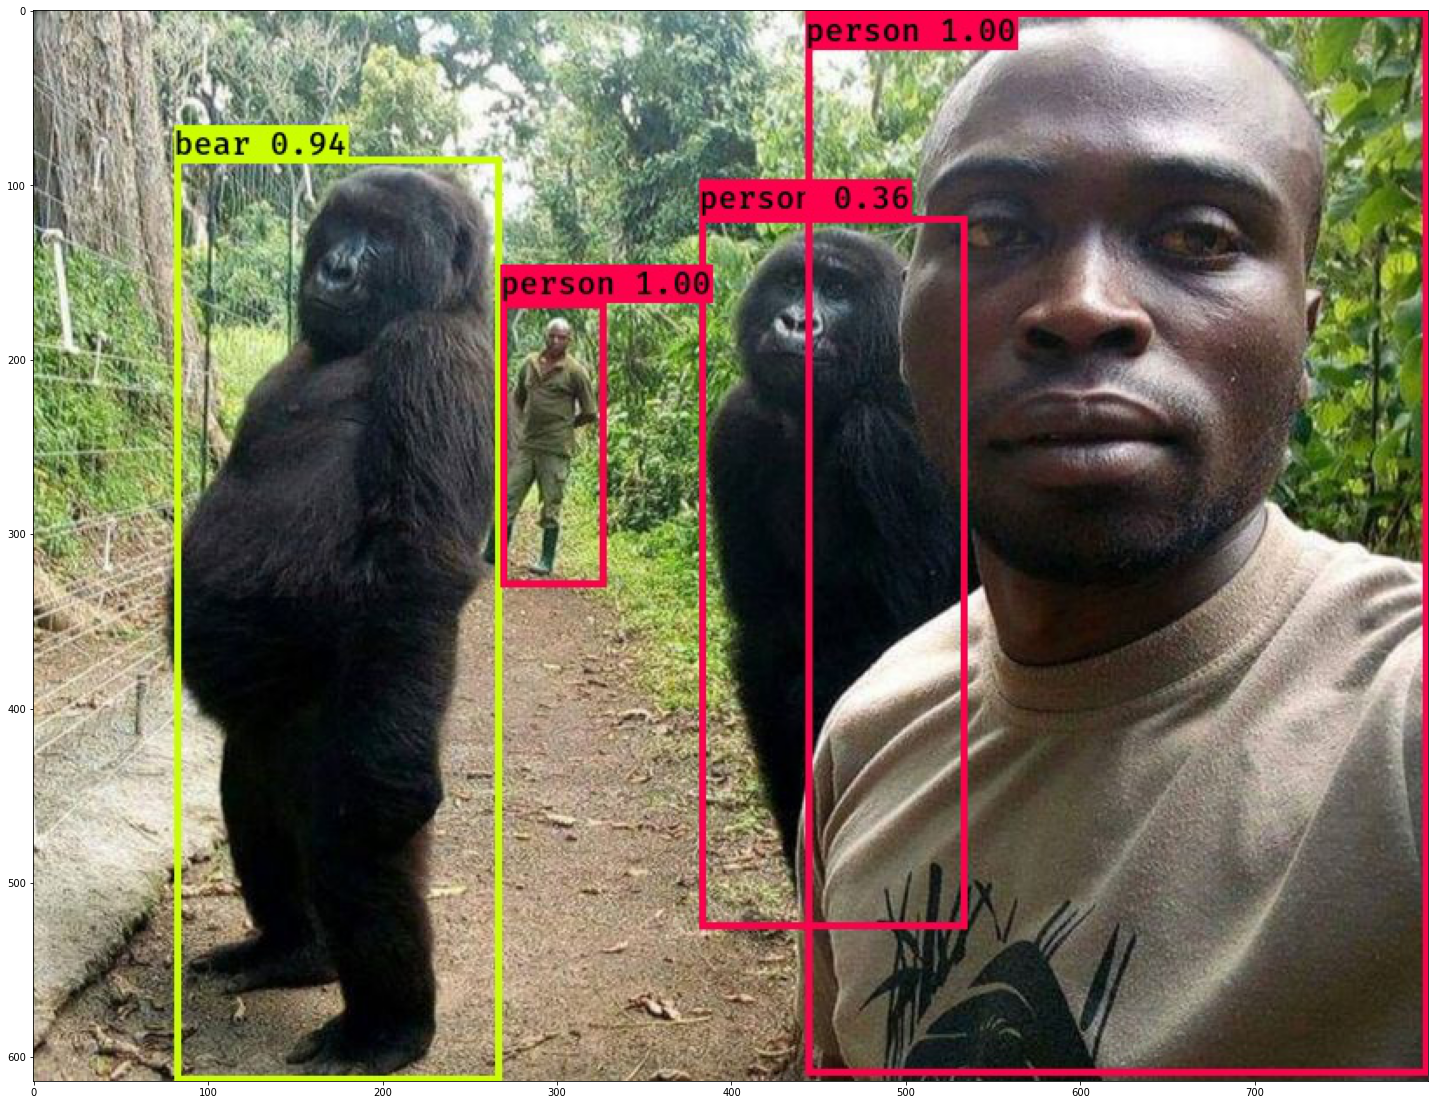

In [34]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
im = Image.open("/content/drive/My Drive/keras-yolo3/out.jpg")
im_list = np.asarray(im)
plt.figure(figsize=(25, 25))
plt.imshow(im_list)
plt.show()

下手にツッコむとやばそうなので特にいうことはないが無事に動作できてよかった

## 【問題4】学習のためのファイルを作成
新しいデータ（シンプソンズデータセット）を学習します。README.mdのTrainingの項を読み、シンプソンズデータセットを学習するために必要なファイルを作成してください。


アノテーションファイルの形式が問題1の実装とは異なるため変換する必要があります。

simpson_modelを作成しその中に

train.txt

classes.txt

を作成

## 【問題5】学習が行えることの確認
問題4で作成したファイルを使用して学習してください。実行環境で学習に時間がかかる場合は、学習が行えることを確認するのみで終えて構いません。

In [17]:
!python convert.py -w yolov3.cfg yolov3.weights simpson_model/yolo_weights.h5

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:520: FutureWarn

In [21]:
!python train.py

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:520: FutureWarn

動作しているのでよし

## 【問題6】（アドバンス課題）コードリーディング
上記実装のコードリーディングを行ってください。


まず、YOLOv3[2]の論文において重要だと考えた部分を列挙してください。そして、それに対応するコードを見つけてください。